In [1]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%matplotlib inline


df = pd.read_csv('./winemag-data_first150k.csv', index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


数据摘要
设置：标称属性Nominal properties和数值属性Numeric properties
标称属性里给出每个可能取值的频数

In [2]:
nominal_properties = df.select_dtypes(exclude=np.number).columns.values
print('Nominal properties为:', nominal_properties)
for name in nominal_properties:
    print(df.groupby(name).size())

Nominal properties为: ['country' 'description' 'designation' 'province' 'region_1' 'region_2'
 'variety' 'winery']
country
Albania                       2
Argentina                  5631
Australia                  4957
Austria                    3057
Bosnia and Herzegovina        4
Brazil                       25
Bulgaria                     77
Canada                      196
Chile                      5816
China                         3
Croatia                      89
Cyprus                       31
Czech Republic                6
Egypt                         3
England                       9
France                    21098
Georgia                      43
Germany                    2452
Greece                      884
Hungary                     231
India                         8
Israel                      630
Italy                     23478
Japan                         2
Lebanon                      37
Lithuania                     8
Luxembourg                    9
Macedonia     

数值属性，给出5数概括及缺失值的个数

In [3]:
numeric_properties = df.select_dtypes(include=np.number).columns.values
print('Numeric properties为:', numeric_properties)
describe = df.describe()
total = len(df)
data = {}
for field in describe.columns:
    data[field] = total - describe[field]['count']

describe = describe.append(pd.Series(data, name='miss'))
describe

Numeric properties为: ['points' 'price']


,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000
miss,0.000000,13695.000000


数据可视化
1.绘制用直方图  由图可得points符合正态分布，price不符合正态分布

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A57D6C1FD0>,
      dtype=object)

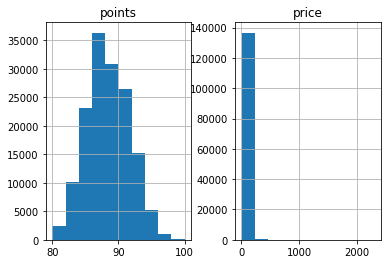

In [4]:
df.hist()

2.绘制盒图

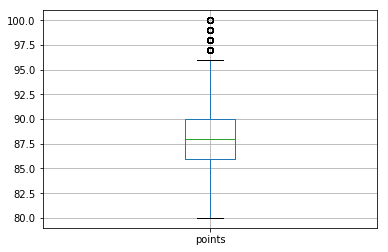

In [5]:
df.boxplot('points')

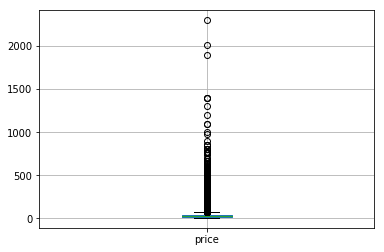

In [6]:
df.boxplot('price')

数据缺失的处理
观察数据集中缺失的数据

In [7]:
total = len(df)
data = {'counts': {}, 'percent': {}}
for field in df.columns:
    data['counts'][field] = total - df[field].count()
    data['percent'][field] = (total - df[field].count())/total
pd.DataFrame(data)

,counts,percent
country,5,0.000033
description,0,0.000000
designation,45735,0.303021
points,0,0.000000
price,13695,0.090737
province,5,0.000033
region_1,25060,0.166037
region_2,89977,0.596151
variety,0,0.000000
winery,0,0.000000


country、designation、price、region_1和region_2中缺失部分数据，和地区相关的数据缺失的原因可能是，漏填记录
price缺失可能是没有市场价格，漏填

将缺失部分剔除

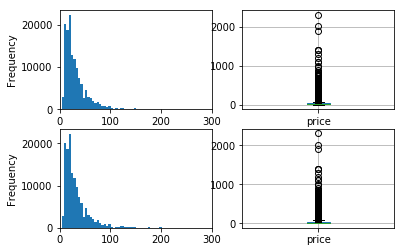

In [8]:
def draw(dataframe, a):
    plt.subplot(2, 2, 1+2*a)
    dataframe['price'].plot.hist(bins=500, xlim=(0, 300))
    plt.subplot(2, 2, 2+2*a)
    dataframe.boxplot('price')

df2= df.dropna(subset=['price'])
draw(df, 0)
draw(df2, 1)

用最高频率值来填补缺失值

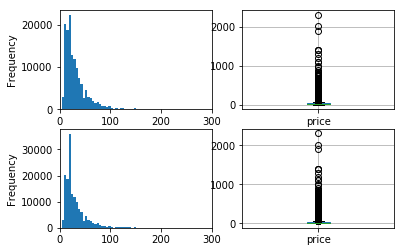

In [9]:
mode = df.mode()['price'][0]
df2 = df.fillna({'price': mode})
draw(df, 0)
draw(df2, 1)

通过属性的相关关系来填补缺失值

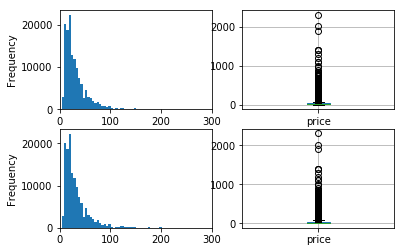

In [10]:
x = df.corr()
points = df['points']
price = df['price']
model = sm.OLS(price,points).fit()
df2 = df
for i in range(len(df2)):
    if(np.isnan(df2['price'][i])):
        df2.loc[i,'price'] = model.predict(df2['points'][i])
draw(df, 0)
draw(df2, 1)

通过数据对象之间的相似性来填补缺失值

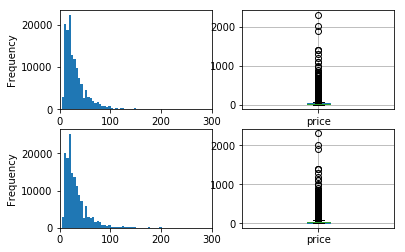

In [14]:
df_sim = df[['price','points']]
p = {}
for row in df_sim.iterrows():
    if p.get(row[1]['points'], None):
        if not np.isnan(row[1]['price']):
            p[row[1]['points']][0] += row[1]['price']
            p[row[1]['points']][1] += 1
    else:
        if not np.isnan(row[1]['price']):
            p[row[1]['points']] = [row[1]['price'], 1]
for k in p.keys():
    p[k][0] = round(p[k][0] / p[k][1], 4)
for i in range(len(df_sim['price'])):
    if (np.isnan(df_sim['price'][i])):
        da = p[df_sim.loc[i, 'points']][0]
        df_sim.loc[i, 'price']  = da
draw(df, 0)
draw(df_sim, 1)